In [2]:
using Statistics
using DataFrames
using Queryverse
using VegaLite
using MLJ
using ShapML

## Data Load

* The titanic data was loaded from a .csv file

In [3]:
#readtable("data.csv")
#For Graphs
titanic = Queryverse.load("/home/chigball/Data/train.csv") |>
@select(-:PassengerId, -:Name, -:Ticket, -:Cabin) |>
@mutate(Survived = string(_.Survived)) |>
DataFrame;



## Data Summary

* The variable "Embarked" has a couple of values missing, so it will be filtered out.  

In [4]:
describe(titanic)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,Type
1,Survived,,0,,1,2,,String
2,Pclass,2.30864,1,3.0,3,,,Int64
3,Sex,,female,,male,2,,String
4,Age,29.6991,0.42,28.0,80.0,,177,"Union{Missing, Float64}"
5,SibSp,0.523008,0,0.0,8,,,Int64
6,Parch,0.381594,0,0.0,6,,,Int64
7,Fare,32.2042,0.0,14.4542,512.329,,,Float64
8,Embarked,,,,S,4,,String


## Data Exploration 

In [5]:
# Data For exploration 

titanic_e = Queryverse.load("/home/chigball/Data/train.csv") |>
@select(-:PassengerId, -:Name, -:Ticket, -:Cabin) |>
@filter(isna(_.Embarked) == false) |>
DataFrame


titanic_e |> @filter(_.Age >= 60) |> DataFrame

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
,Int64,Int64,String,Float64⍰,Int64,Int64,Float64,String
1,0,2,male,66.0,0,0,10.5,S
2,0,1,male,65.0,0,1,61.9792,C
3,0,1,male,71.0,0,0,34.6542,C
4,0,3,male,70.5,0,0,7.75,Q
5,0,1,male,61.0,0,0,33.5,S
6,0,1,male,62.0,0,0,26.55,S
7,1,1,female,63.0,1,0,77.9583,S
8,0,3,male,65.0,0,0,7.75,Q
9,0,3,male,61.0,0,0,6.2375,S


In [6]:
## Plot for Pclass
p1 =
@vlplot(
  data = titanic_e,
  mark = :bar,
  x = "Pclass:n",
  y = {"mean(Survived)", title = "Survival Rate"},
  height = 200,
  width = 200,
);

## Plot for Sex
p2 =
@vlplot(
  data = titanic_e,
  mark = :bar,
  x = "Sex:n",
  y = {"mean(Survived)", title = "Survival Rate"},
  height = 200,
  width = 200,
);


## Plot for SibSp
p3 =
@vlplot(
  data = titanic_e,
  mark = :bar,
  x = "SibSp:n",
  y = {"mean(Survived)", title = "Survival Rate"},
  height = 200,
  width = 200,
);


## Plot for Embarked
p4 =
@vlplot(
  data = titanic_e,
  mark = :bar,
  x = "Embarked:n",
  y = {"mean(Survived)", title = "Survival Rate"},
  height = 200,
  width = 200,
);


# Plot of Fare

p5 = @vlplot(
  data = titanic_e,
  mark = :bar,
  x = "Survived:n",
  y = {"mean(Fare)", title = "Average Fare"},
  width = 200,
  height = 200
);

# Plot of Age

p6 = @vlplot(
  data = titanic_e,
  mark = :bar,
  x = {"Sex:n", title = ""},
  y = {"mean(Survived)", title = "Survival Rate"},
  column = {"Age", bin = true, title = "Survival by Age and Gender"},
  color = "Sex:n"

);

### Obervations 1

* Age does not make much difference to the survival rate. A few >60 year old females had a perfect survival rate only because sample sizes were low.

* Higher class people had a higher survival rate.

* Females had a higher survival rate than males.

* People with 1 or 2 siblings onboard tend to fare the best compared to people no siblings or > 2 siblings.

* Embarkation from Cherbourg was assoicated with higer survial rate.

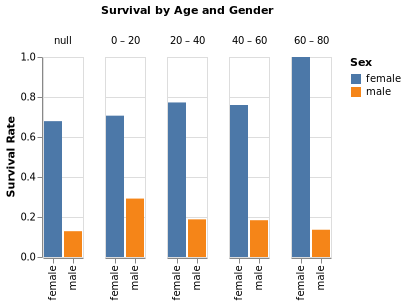

In [7]:
p6

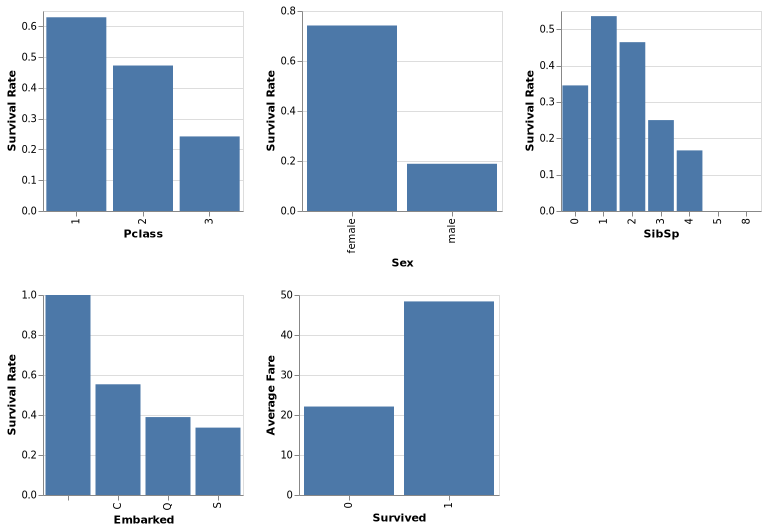

In [8]:
[[p1 p2 p3 ]; [p4 p5]]

In [9]:
# Schema of the data
schema(titanic)

┌──────────┬─────────────────────────┬────────────────────────────┐
│ _.names  │ _.types                 │ _.scitypes                 │
├──────────┼─────────────────────────┼────────────────────────────┤
│ Survived │ String                  │ Textual                    │
│ Pclass   │ Int64                   │ Count                      │
│ Sex      │ String                  │ Textual                    │
│ Age      │ Union{Missing, Float64} │ Union{Missing, Continuous} │
│ SibSp    │ Int64                   │ Count                      │
│ Parch    │ Int64                   │ Count                      │
│ Fare     │ Float64                 │ Continuous                 │
│ Embarked │ String                  │ Textual                    │
└──────────┴─────────────────────────┴────────────────────────────┘
_.nrows = 891


## Model Building 

* An initial pipeline is built to predict survival
* The pipeline consists of a fill-imputer, onehotencoder and a randomforest-classifier

In [10]:
# Filter out missing Sex
titanic = titanic |> @filter(isna(_.Embarked)==false) |> DataFrame

# Choose X
X = titanic |> 
@select(-:Survived) |>  
DataFrame;

# Choose y
y = categorical(titanic.Survived);

## *Maybe when unpacking just change the SciType of target*
# y1, X1 = unpack(titanic, ==(:Survived), colname -> true; :Survived=>Multiclass);
## *Change SciType of X when pushing through the pipeline*

# Choose mapping
D2 = Dict(
  :Pclass=>Multiclass, 
  :Sex=>Multiclass, 
  :SibSp=>Continuous, 
  :Parch=>Continuous, 
  :Fare=>Continuous,
  :Embarked=>Union{Missing,Multiclass});

# Load models
@load FillImputer # Import FillImputer model
@load OneHotEncoder # Import OneHotEncoder model
@load RandomForestClassifier pkg="DecisionTree"  # Import DecisionTreeClassifier model


# Create a model composite pipeline
pipe = @pipeline MyPipe(
  X -> coerce(X, D2),
  fill = FillImputer(),
  hot = OneHotEncoder(),
  dtc = RandomForestClassifier()
) prediction_type=:probabilistic  #  Remember to fucking do this


┌ Info: A model type "FillImputer" is already loaded. 
│ No new code loaded. 
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/i4XcU/src/loading.jl:43
┌ Info: A model type "OneHotEncoder" is already loaded. 
│ No new code loaded. 
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/i4XcU/src/loading.jl:43


MyPipe(
    fill = FillImputer(
            features = Symbol[],
            continuous_fill = MLJModels.var"#32#33"(),
            count_fill = MLJModels.var"#34#36"(),
            finite_fill = MLJModels.var"#38#39"()),
    hot = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    dtc = RandomForestClassifier(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 0,
            n_trees = 10,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0)) @ 1…52

In [11]:
# Fit a machine from the pipeline

mach = machine(pipe, X, y)
fit!(mach)


┌ Info: Training Machine{MyPipe} @ 1…30.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Training NodalMachine{FillImputer} @ 3…22.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Training NodalMachine{OneHotEncoder} @ 9…61.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Spawning 3 sub-features to one-hot encode feature :Pclass.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/i4XcU/src/builtins/Transformers.jl:762
┌ Info: Spawning 2 sub-features to one-hot encode feature :Sex.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/i4XcU/src/builtins/Transformers.jl:762
┌ Info: Spawning 4 sub-features to one-hot encode feature :Embarked.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/i4XcU/src/builtins/Transformers.jl:762
┌ Info: Training NodalMachine{RandomForestClassifier} @ 7…67.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187


Machine{MyPipe} @ 1…30


## Model Evaluation 
* Define resampling strategy
* Define measures

In [12]:
evaluate!(mach, 
  resampling=CV(nfolds=6, rng=1234),
  measures=[cross_entropy, BrierScore(), area_under_curve],  
  check_measure=false
)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:02


┌──────────────────────────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure                    │ _.measurement │ _.per_fold                                       │
├──────────────────────────────┼───────────────┼──────────────────────────────────────────────────┤
│ cross_entropy                │ 1.63          │ [1.04, 2.26, 1.52, 1.41, 1.1, 2.48]              │
│ BrierScore{UnivariateFinite} │ -0.296        │ [-0.242, -0.326, -0.262, -0.347, -0.292, -0.303] │
│ area_under_curve             │ 0.844         │ [0.881, 0.836, 0.879, 0.805, 0.844, 0.817]       │
└──────────────────────────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [[[0.105, 2.22e-16, ..., 2.22e-16], [2.22e-16, 0.105, ..., 0.357], [0.105, 0.105, ..., 0.357], [1.2, 0.105, ..., 2.22e-16], [0.105, 0.511, ..., 0.511], [1.61, 0.105, ..., 2.22e-16]], [[-0.02, 0.0, ..., 0.0], [0.0, -0.02, ..., -0.18], [-0.02, -0.02, ..., -0.18], [-0.98, -0.02, ...

## Model Tuning

In [13]:
# Inspect pipe

pipe


MyPipe(
    fill = FillImputer(
            features = Symbol[],
            continuous_fill = MLJModels.var"#32#33"(),
            count_fill = MLJModels.var"#34#36"(),
            finite_fill = MLJModels.var"#38#39"()),
    hot = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    dtc = RandomForestClassifier(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 0,
            n_trees = 10,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0)) @ 1…52

In [14]:
# Define ranges for tuning

r1 = range(pipe, :(dtc.max_depth), lower=-1, upper = 20) # 6 is optimal
r2 = range(pipe, :(dtc.n_trees), lower=5, upper = 20) # 15 is optimal

# Tuning paramaters
pipe.dtc.max_depth = 6;
pipe.dtc.n_trees = 15;

# Refit the machine
mach = machine(pipe, X, y)
fit!(mach)

┌ Info: Training Machine{MyPipe} @ 2…37.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Training NodalMachine{FillImputer} @ 1…56.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Training NodalMachine{OneHotEncoder} @ 3…32.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Spawning 3 sub-features to one-hot encode feature :Pclass.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/i4XcU/src/builtins/Transformers.jl:762
┌ Info: Spawning 2 sub-features to one-hot encode feature :Sex.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/i4XcU/src/builtins/Transformers.jl:762
┌ Info: Spawning 4 sub-features to one-hot encode feature :Embarked.
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/i4XcU/src/builtins/Transformers.jl:762
┌ Info: Training NodalMachine{RandomForestClassifier} @ 9…75.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187


Machine{MyPipe} @ 2…37


## Learning Curves
* These curves allow us to tune the parameters of models

In [15]:
# Create 2 learning curves

curve1 = learning_curve(mach; range=r1, resampling=CV(), measure=cross_entropy);
curve2 = learning_curve(mach; range=r2, resampling=CV(), measure=cross_entropy);


┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @ 3…98.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Attempting to evaluate 22 models.
└ @ MLJTuning /home/chigball/.julia/packages/MLJTuning/JZ7ZX/src/tuned_models.jl:501
Evaluating over 22 metamodels: 100%[=========================] Time: 0:00:02
┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @ 9…63.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Attempting to evaluate 16 models.
└ @ MLJTuning /home/chigball/.julia/packages/MLJTuning/JZ7ZX/src/tuned_models.jl:501
Evaluating over 16 metamodels: 100%[=========================] Time: 0:00:01


In [16]:
# Function to plot learning curves

function plot_lc(curve::NamedTuple, measure::String)
  
  # Create a dataframe from data
  df = DataFrame(parameter_values = curve.parameter_values, measurements = curve.measurements)
  
  # Use vlplot to plot data  
  @vlplot(
    data = df,
    mark = {:line, tooltip = true, point = true},
    x = {"parameter_values:q", title = curve.parameter_name},
    y = {"measurements:q", title = measure},
    title = "Learning Curve",
    height = 250,
    width = 260
  )  

end

plot_lc (generic function with 1 method)

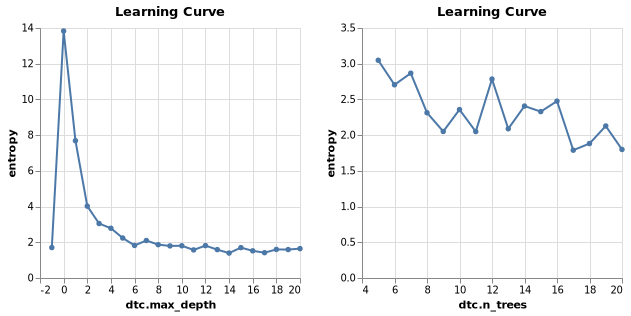

In [17]:
# First learning curve
p1 = plot_lc(curve1, "entropy");

# Second learning curve
p2 = plot_lc(curve2, "entropy");

pl = [p1 p2]

In [54]:
report(mach).machines

3-element Array{Any,1}:
 NodalMachine @ 9…75 = machine(RandomForestClassifier @ 1…46, 9…70, 2…56)
 NodalMachine @ 3…32 = machine(OneHotEncoder @ 3…24, 9…47)
 NodalMachine @ 1…56 = machine(FillImputer @ 1…27, 7…87)

In [67]:
using Pkg
Pkg.add("GLM")


@load Standardizer
X, y = @load_crabs;
pipe2 = @pipeline(Standardizer(), RandomForestClassifier()) 
mach2 = machine(pipe2, X, y) 

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
┌ Info: A model type "Standardizer" is already loaded. 
│ No new code loaded. 
└ @ MLJModels /home/chigball/.julia/packages/MLJModels/i4XcU/src/loading.jl:43


LoadError: LoadError: ArgumentError: @pipeline error 11. 
in expression starting at In[67]:7

In [70]:
using MLJ
pipe2 = @pipeline(
  Standardizer(),
  NeuralNetworkClassifier(builder = MyANNBuilder(10,10), epochs = 8, batch_size = 1),
  prediction_type=:probabilistic
)

LoadError: LoadError: MethodError: no method matching pipeline_(::Module, ::Expr, ::Expr, ::Expr)
Closest candidates are:
  pipeline_(::Any, ::Any, ::Any) at /home/chigball/.julia/packages/MLJBase/O5b6j/src/composition/pipelines.jl:230
  pipeline_(::Any, ::Any) at /home/chigball/.julia/packages/MLJBase/O5b6j/src/composition/pipelines.jl:263
in expression starting at In[70]:2